In [1]:
import mlflow
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline, make_pipeline
from category_encoders import BinaryEncoder
from sklearn.compose import ColumnTransformer

In [ ]:
class BasicExplorer:
    """
    Una clase que proporciona herramientas básicas de análisis exploratorio de datos para un DataFrame de pandas.

    Métodos
    -------
    basic_info(data: pd.DataFrame)
        Imprime las primeras filas, estadísticas descriptivas y un resumen de información del DataFrame.
    
    histograms(data: pd.DataFrame)
        Muestra histogramas para cada columna numérica en el DataFrame.
    
    correlation_matrix(data: pd.DataFrame)
        Muestra un mapa de calor de la matriz de correlación para columnas seleccionadas, 
        convirtiendo valores categóricos en booleanos para el análisis de correlación.
    """

    @staticmethod
    def basic_info(data: pd.DataFrame):
        """
        Imprime un resumen de los datos, que incluye las primeras filas, estadísticas básicas
        e información sobre los tipos de datos.

        Parámetros
        ----------
        data : pd.DataFrame
            El DataFrame a analizar.
        """
        print(data.head())
        print(data.describe())
        print(data.info())

    def histograms(data: pd.DataFrame):
        """
        Grafica histogramas para cada columna numérica en el DataFrame.

        Parámetros
        ----------
        data : pd.DataFrame
            El DataFrame que contiene los datos a graficar.
        """
        data.hist(bins=15, figsize=(15,10))
        plt.show()

    def correlation_matrix(data: pd.DataFrame):
        """
        Crea y muestra un mapa de calor de la matriz de correlación para columnas específicas,
        convirtiendo valores categóricos en booleanos para el cálculo de correlación.

        Parámetros
        ----------
        data : pd.DataFrame
            El DataFrame que contiene los datos a analizar.
        
        Notas
        -----
        Este método asume la presencia de columnas categóricas específicas:
        - 'Gender' debe contener valores 'Male' y 'Female'.
        - Otras columnas se asumen como binarias con valores 'Yes' y 'No'.
        """
        aux_data = pd.DataFrame()
        aux_data['Gender'] = data['Gender'] == 'Male'
        for column in data.columns[2:-1]:
            aux_data[column] = data[column] == 'Yes'
        aux_data['class'] = data['class'] == 'Positive'
        plt.figure(figsize=(12,8))
        sns.heatmap(aux_data.corr(numeric_only=True), annot=True, fmt=".2f", cmap="coolwarm")

In [ ]:
class DiabetesRisk:
    """
    Clase para analizar y predecir el riesgo de diabetes usando modelos de regresión logística.
    Proporciona métodos para cargar y preprocesar datos, entrenar y evaluar el modelo,
    y realizar validación cruzada.

    Atributos
    ---------
    filepath : str
        Ruta al archivo CSV que contiene los datos.
    use_mlflow : bool, opcional
        Si se establece en True, habilita el registro automático de experimentos usando mlflow.
    X_train, X_test, y_train, y_test : pd.DataFrame o None
        Conjuntos de entrenamiento y prueba para las variables independientes y dependientes.

    Métodos
    -------
    create_pipeline()
        Crea el pipeline de preprocesamiento y modelo, y lo asigna al atributo `pipeline`.
    
    load_data()
        Carga los datos desde el archivo CSV, y muestra información básica y visualizaciones de exploración.
    
    preprocess_data()
        Preprocesa los datos, separando variables independientes y dependientes, 
        y realiza la división en conjuntos de entrenamiento y prueba.
    
    train_model()
        Entrena el modelo en el conjunto de datos de entrenamiento.
    
    evaluate_model()
        Evalúa el modelo en el conjunto de prueba, mostrando la matriz de confusión 
        y el reporte de clasificación.
    
    cv_model()
        Realiza validación cruzada del modelo y muestra la precisión promedio.
    """
    def __init__(self, filepath, use_mlflow=False):
        """
        Inicializa la clase DiabetesRisk con la ruta del archivo y la opción de uso de mlflow.

        Parámetros
        ----------
        filepath : str
            Ruta al archivo CSV con los datos.
        use_mlflow : bool, opcional
            Si es True, activa el registro automático de experimentos usando mlflow (predeterminado es False).
        """
        self.filepath = filepath
        #self.pipeline = self.create_pipeline()
        self.X_train, self.X_test, self.y_train, self.y_test = [None] * 4
        if use_mlflow:
            mlflow.autolog()
            mlflow.set_tracking_uri(uri="http://127.0.0.1:5000")
            mlflow.set_experiment("Default")

    def create_pipeline(self):
        """
        Crea el pipeline de preprocesamiento y modelo de regresión logística.

        El pipeline incluye el escalado de variables numéricas y la codificación binaria de variables categóricas.
        Asigna el pipeline al atributo `self.pipeline`.

        Return
        -------
        self : DiabetesRisk
            La instancia actual con el pipeline configurado.
        """
        numeric_pipeline = Pipeline(
            steps=[
                ("scaler", StandardScaler()),
            ]
        )
        categorical_pipeline = Pipeline(
            steps=[
                ("binary", BinaryEncoder())
            ]
        )
        preprocessor = ColumnTransformer(
            [
                ("categorical", categorical_pipeline, self.data.columns[1:-1].to_list()),
                ("numerical", numeric_pipeline, self.data.columns[:1].to_list())
            ]
        )
        self.pipeline = make_pipeline(preprocessor, LogisticRegression(max_iter=1000))
        return self

    def load_data(self):
        """
        Carga los datos desde un archivo CSV, y realiza una exploración inicial.

        Utiliza la clase `BasicExplorer` para mostrar las primeras filas, estadísticas descriptivas, 
        histogramas y la matriz de correlación.

        Return
        -------
        self : DiabetesRisk
            La instancia actual con los datos cargados.
        """
        self.data = pd.read_csv(self.filepath)
        BasicExplorer.basic_info(self.data)
        BasicExplorer.histograms(self.data)
        BasicExplorer.correlation_matrix(self.data)
        return self
    
    def preprocess_data(self):
        """
        Preprocesa los datos para el entrenamiento del modelo.

        Separa las variables independientes (X) y la variable dependiente (y), 
        y realiza la división en conjuntos de entrenamiento y prueba.

        Return
        -------
        self : DiabetesRisk
            La instancia actual con los datos preprocesados.
        """
        X = self.data.drop('class', axis=1)
        y = self.data['class']
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X, y, test_size=0.2, random_state=35)
        return self
    
    def train_model(self):
        """
        Entrena el modelo en el conjunto de datos de entrenamiento.

        Ajusta el pipeline de regresión logística usando `self.X_train` y `self.y_train`.

        Return
        -------
        self : DiabetesRisk
            La instancia actual con el modelo entrenado.
        """
        self.pipeline.fit(self.X_train, self.y_train)
        return self
    
    def evaluate_model(self):
        """
        Evalúa el rendimiento del modelo en el conjunto de prueba.

        Muestra la matriz de confusión y el reporte de clasificación.

        Return
        -------
        self : DiabetesRisk
            La instancia actual con la evaluación realizada.
        """
        print('-----Evalución del modelo-----')
        y_pred = self.pipeline.predict(self.X_test)
        cm = confusion_matrix(self.y_test, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(self.y_test))
        disp.plot(cmap="Blues")
        plt.show()

        report = classification_report(self.y_test, y_pred)
        print(report)
        return self

    def cv_model(self):
        """
        Realiza validación cruzada del modelo y muestra la precisión promedio.

        Calcula la precisión promedio en 5 particiones (`cv=5`) del conjunto de entrenamiento.

        Return
        -------
        self : DiabetesRisk
            La instancia actual con la validación cruzada realizada.
        """
        scores = cross_val_score(self.pipeline, self.X_train, self.y_train, cv = 5)
        print("Average Accuracy with CV:", np.mean(scores))
        return self




2024/10/11 19:31:09 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2024/10/11 19:31:09 WARNING mlflow.utils.autologging_utils: MLflow statsmodels autologging is known to be compatible with 0.11.1 <= statsmodels <= 0.14.2, but the installed version is 0.14.4. If you encounter errors during autologging, try upgrading / downgrading statsmodels to a compatible version, or try upgrading MLflow.
2024/10/11 19:31:09 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.


   Age Gender Polyuria Polydipsia sudden weight loss weakness Polyphagia  \
0   40   Male       No        Yes                 No      Yes         No   
1   58   Male       No         No                 No      Yes         No   
2   41   Male      Yes         No                 No      Yes        Yes   
3   45   Male       No         No                Yes      Yes        Yes   
4   60   Male      Yes        Yes                Yes      Yes        Yes   

  Genital thrush visual blurring Itching Irritability delayed healing  \
0             No              No     Yes           No             Yes   
1             No             Yes      No           No              No   
2             No              No     Yes           No             Yes   
3            Yes              No     Yes           No             Yes   
4             No             Yes     Yes          Yes             Yes   

  partial paresis muscle stiffness Alopecia Obesity     class  
0              No              Yes      

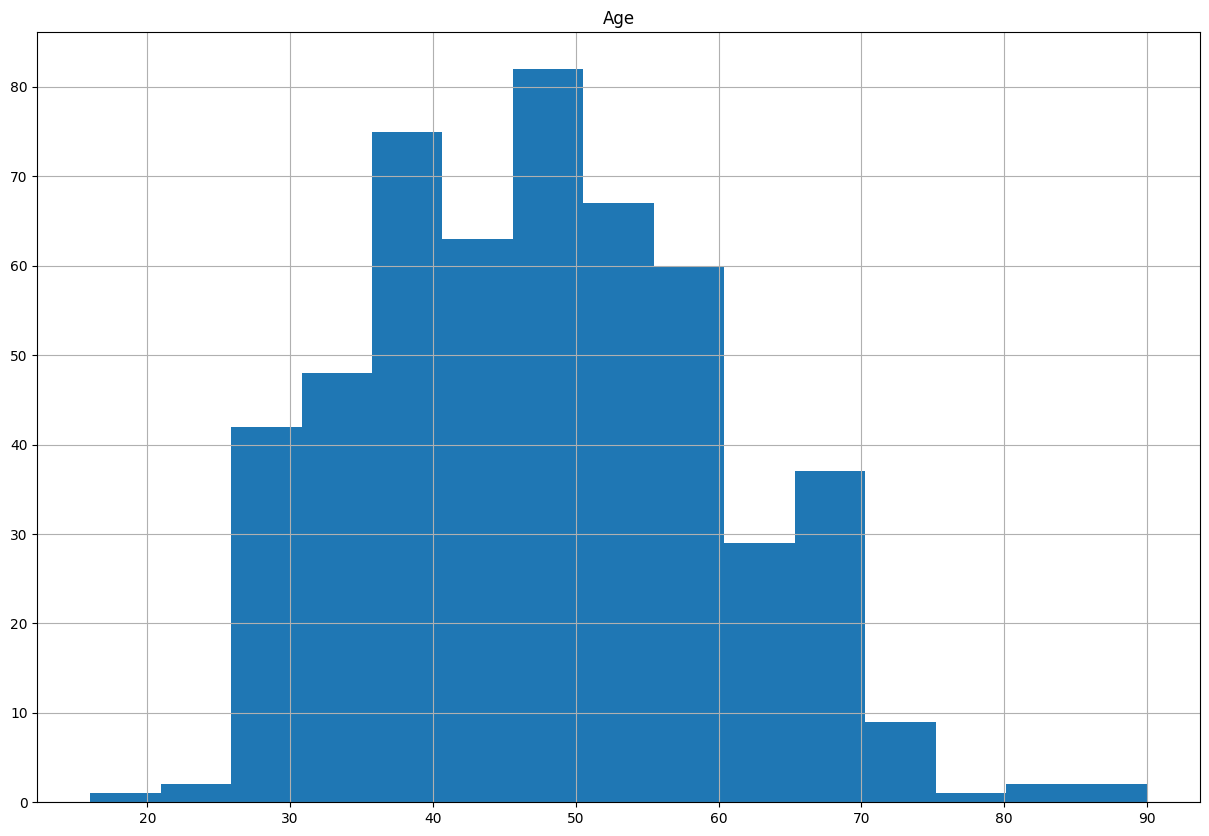

2024/10/11 19:31:11 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '002e4aca84bf4cdb9f23c0c2d6e70d19', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2024/10/11 19:31:47 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\alejandro.aguilar\Downloads\MLOps\diabetes_mlops\venv\lib\site-packages\mlflow\types\utils.py:407: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handl

-----Evalución del modelo-----


2024/10/11 19:32:02 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\alejandro.aguilar\Downloads\MLOps\diabetes_mlops\venv\lib\site-packages\mlflow\types\utils.py:407: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."


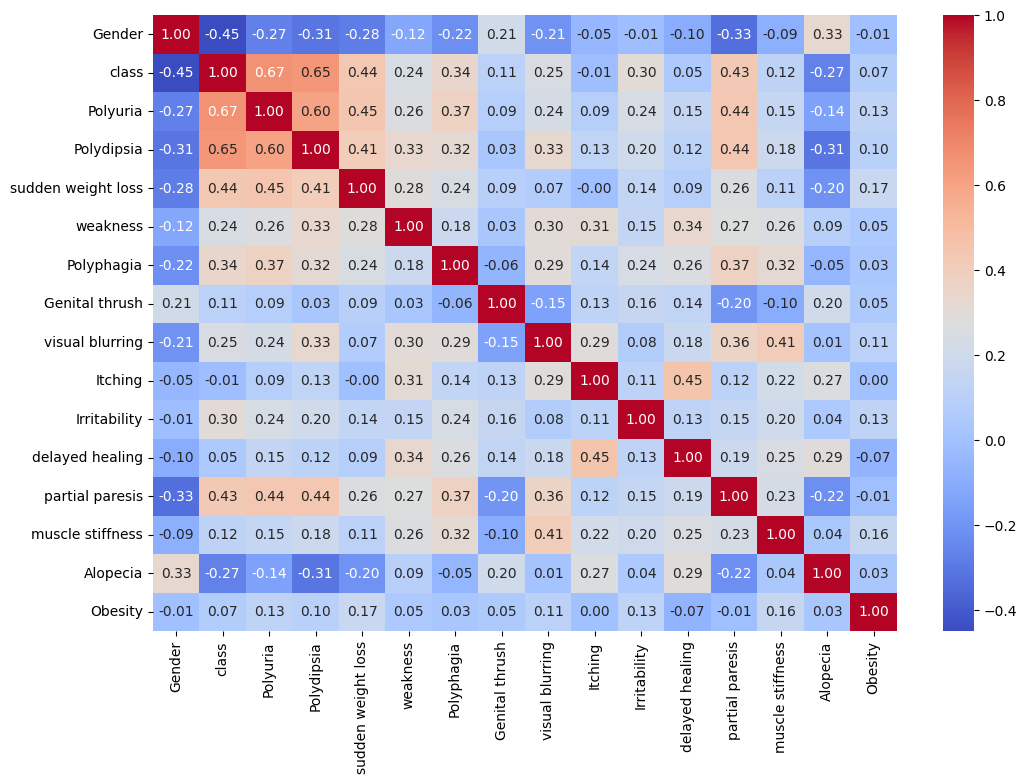

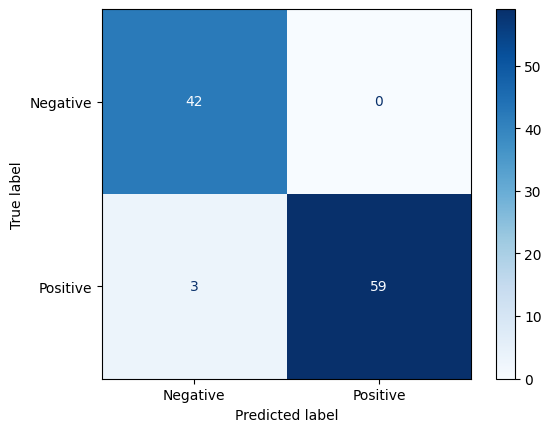

2024/10/11 19:32:03 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '1fc5ee7b89ac4863875cf529dda1843e', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow


              precision    recall  f1-score   support

    Negative       0.93      1.00      0.97        42
    Positive       1.00      0.95      0.98        62

    accuracy                           0.97       104
   macro avg       0.97      0.98      0.97       104
weighted avg       0.97      0.97      0.97       104



2024/10/11 19:32:31 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\alejandro.aguilar\Downloads\MLOps\diabetes_mlops\venv\lib\site-packages\mlflow\types\utils.py:407: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
2024/10/11 19:32:32 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\alejandr

Average Accuracy with CV: 0.9134825014343086


In [7]:
path = r"..\data\raw\diabetes_data_upload.csv"
model = DiabetesRisk(path, True)
model.load_data()
model.create_pipeline()
model.preprocess_data()
model.train_model()
model.evaluate_model()
model.cv_model()